In [ ]:
"""
forgive the horrible notebook and out-of-order execution, this was written after the tournament began,
so it only really will have meaning in 2023 or after
"""

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from scipy.stats import kendalltau

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [14]:
# ! pip install nb-black
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [18]:
# some assumptions gleaned from prior data analysis

# an overtime adds about 7-9 points on average
OVERTIME_SCORE_BONUS = 7.4

# an average game in the dataset has between 70-75 points
MEAN_GAME_SCORE = 74

# a team tends to have an inter-game score standard deviation of about 11 points
STD_GAME_SCORE = 11

SEASON = 2022

<IPython.core.display.Javascript object>

In [146]:
# read in game data, team names, and previously-calculated Elo scores for comparison

games_df = pd.read_csv("./data/MRegularSeasonCompactResults.csv")
teamnames = pd.read_csv("data/MTeams.csv")
elo_df = (
    pd.read_csv("./data/features.csv", usecols=["Season", "TeamID", "elo_16_day0_True"])
    .rename(columns={"elo_16_day0_True": "elo"})
    .drop_duplicates(["Season", "TeamID"])
)

games_df = games_df[games_df.Season == SEASON]
print(games_df.shape)

games_df = (
    pd.merge(
        games_df,
        elo_df,
        how="inner",
        left_on=["Season", "WTeamID"],
        right_on=["Season", "TeamID"],
    )
    .rename(
        columns={
            "elo": "T1elo",
            "WTeamID": "T1TeamID",
            "WScore": "T1Score",
            "WLoc": "T1Loc",
        }
    )
    .drop(columns=["TeamID"])
)
games_df["T1Home"] = games_df.T1Loc.apply(lambda x: 1 if x == "H" else 0)
t2home = games_df.T1Loc.apply(lambda x: 1 if x == "A" else 0).values

games_df = (
    pd.merge(
        games_df,
        elo_df,
        how="inner",
        left_on=["Season", "LTeamID"],
        right_on=["Season", "TeamID"],
    )
    .rename(
        columns={
            "elo": "T2elo",
            "LTeamID": "T2TeamID",
            "LScore": "T2Score",
        }
    )
    .drop(columns=["TeamID", "DayNum"])
)
renames = {c: "T2" + c[2:] for c in games_df.columns if c[:2] == "T1" and c != "T1Home"}
renames.update({c: "T1" + c[2:] for c in games_df.columns if c[:2] == "T2"})
inv_games_df = games_df.copy().rename(columns=renames)
inv_games_df["T1Home"] = t2home
games_df = (
    pd.concat([games_df, inv_games_df])
    .drop(columns=["T2Loc", "T2Score"])
    .reset_index(drop=True)
)

games_df = games_df[games_df.NumOT < 2]
games_df["T1Score"] = games_df[["T1Score", "NumOT"]].apply(
    lambda x: x[0] - OVERTIME_SCORE_BONUS * x[1], axis=1
)

(5345, 8)


<IPython.core.display.Javascript object>

In [147]:
games_df

,Season,T1TeamID,T1Score,T2TeamID,T1Loc,NumOT,T1elo,T1Home,T2elo
0,2022,1104,93.0,1256,H,0,1593.672816,1,1617.406148
1,2022,1261,66.0,1256,N,0,1633.255567,0,1617.406148
2,2022,1301,90.0,1256,H,0,1412.156176,1,1617.406148
3,2022,1412,83.0,1256,A,0,1721.895340,0,1617.406148
4,2022,1412,87.0,1256,H,0,1721.895340,1,1617.406148
...,...,...,...,...,...,...,...,...,...
10685,2022,1369,63.0,1404,NaN,0,1449.623967,0,1284.178941
10686,2022,1369,94.0,1399,NaN,0,1449.623967,1,1406.936488
10687,2022,1369,68.0,1286,NaN,0,1449.623967,0,1673.664254
10688,2022,1369,65.6,1287,NaN,1,1449.623967,0,1563.620680


<IPython.core.display.Javascript object>

In [148]:
# factorize turns our team IDs into sequential ints like [0, 1, 2, ...]
t1_idx, teams = pd.factorize(games_df["T1TeamID"], sort=True)
t2_idx, _ = pd.factorize(games_df["T2TeamID"], sort=True)
game_ids = games_df.index.values

<IPython.core.display.Javascript object>

In [153]:
# shape of this is taken from Rugby Analytics example here:
# https://oriolabril.github.io/oriol_unraveled/python/arviz/pymc3/xarray/2020/09/22/pymc3-arviz.html
coords = {"team": teams, "game": game_ids}

with pm.Model(coords=coords) as model:
    # constant data
    t1 = pm.Data("t1", t1_idx, dims="game")
    t2 = pm.Data("t2", t2_idx, dims="game")

    # team-specific model parameters
    offense = pm.Normal("offense", mu=50, sigma=10, dims="team")
    defense = pm.Normal("defense", mu=50, sigma=10, dims="team")
    scaler = pm.Uniform("scaler", lower=0.3, upper=1.0)
    base = pm.Normal("base", mu=70, sigma=3)

    t1_score = pm.Deterministic(
        "score", (offense[t1_idx] - defense[t2_idx]) * scaler + base
    )

    # likelihood of observed data
    t1_pts = pm.Normal(
        "t1_points", mu=t1_score, sigma=5, observed=games_df.T1Score, dims=("game")
    )

    trace = pm.sample(
        1000, tune=2000, cores=4, return_inferencedata=True, target_accept=0.9
    )

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [base, scaler, defense, offense]
INFO:pymc3:NUTS: [base, scaler, defense, offense]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 171 seconds.
INFO:pymc3:Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 171 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'scaler'}>,
        <AxesSubplot:title={'center':'scaler'}>],
       [<AxesSubplot:title={'center':'base'}>,
        <AxesSubplot:title={'center':'base'}>]], dtype=object)

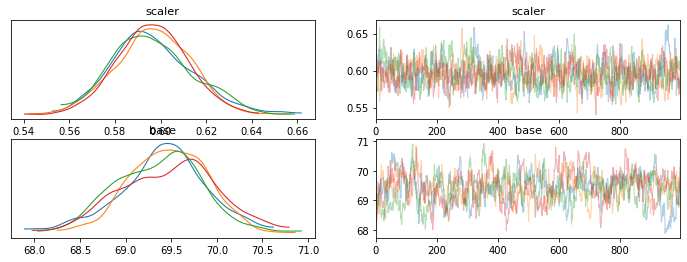

<IPython.core.display.Javascript object>

In [154]:
az.plot_trace(
    trace,
    var_names=[
        "scaler",
        "base",
    ],
    compact=False,
)

In [155]:
az.summary(trace, kind="diagnostics")

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
offense[1101],0.042,0.030,1718.0,2262.0,1.00
offense[1102],0.049,0.035,1290.0,2609.0,1.00
offense[1103],0.045,0.032,1346.0,2251.0,1.01
offense[1104],0.049,0.035,1207.0,2054.0,1.00
offense[1105],0.054,0.039,1117.0,1840.0,1.01
...,...,...,...,...,...
score[10593],0.013,0.009,9918.0,2949.0,1.00
score[10594],0.014,0.010,8855.0,3199.0,1.00
score[10595],0.015,0.011,7208.0,3197.0,1.00
score[10596],0.013,0.009,10343.0,2844.0,1.00


<IPython.core.display.Javascript object>

In [157]:
trace_hdi = az.hdi(trace)

<IPython.core.display.Javascript object>

In [164]:
ratings_df = pd.DataFrame(
    list(
        zip(
            trace_hdi["offense"].team.values,
            trace_hdi["offense"].values[:, 0],
            trace_hdi["defense"].values[:, 0],
        )
    ),
    columns=["TeamID", "OffensiveRating", "DefensiveRating"],
)
ratings_df["Season"] = 2022
ratings_df

,TeamID,OffensiveRating,DefensiveRating,Season
0,1101,51.119725,47.131761,2022
1,1102,32.910029,52.945404,2022
2,1103,41.451038,54.587158,2022
3,1104,72.520720,46.707659,2022
4,1105,25.419944,46.413620,2022
...,...,...,...,...
353,1468,41.984361,47.048038,2022
354,1469,44.497944,36.293208,2022
355,1470,36.472518,53.191780,2022
356,1471,45.224948,38.061488,2022


<IPython.core.display.Javascript object>

elo    1823.148388
Name: (2022, 1112), dtype: float64

<IPython.core.display.Javascript object>

0.2882179929061971

<IPython.core.display.Javascript object>

In [172]:
features = pd.read_csv("./data/features.csv").drop_duplicates(["Season", "TeamID"])

joined = pd.merge(
    ratings_df,
    features,
    how="inner",
    left_on=["Season", "TeamID"],
    right_on=["Season", "TeamID"],
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [174]:
joined

,TeamID,OffensiveRating,DefensiveRating,Season,elo_16_day0_False,elo_16_day0_True,elo_16_day30_False,elo_16_day30_True,elo_16_day60_False,elo_16_day60_True,...,Pt_adj,Win_adj,OppElo,best_team_beaten_elo,Win,adj_o,adj_d,luck,rank,adj_em
0,1101,51.119725,47.131761,2022,1539.290630,1588.202098,1548.237279,1599.680718,1525.753071,1569.565272,...,5.117100,0.419073,0.639638,1634.223440,0.692308,102.9,99.3,0.028,127.0,3.59
1,1102,32.910029,52.945404,2022,1448.694899,1374.170020,1421.557225,1341.745803,1422.886453,1337.675277,...,0.792188,0.102518,0.270276,1644.402744,0.227273,95.9,103.9,0.068,261.0,-8.04
2,1103,41.451038,54.587158,2022,1578.065555,1650.709138,1584.465074,1666.792642,1573.132064,1654.629714,...,5.417437,0.525038,0.739826,1720.268710,0.769231,106.0,102.7,0.026,134.0,3.22
3,1104,72.520720,46.707659,2022,1543.089447,1593.672816,1509.444837,1520.535467,1494.100441,1483.523313,...,3.435038,0.303562,0.511262,1868.789325,0.520000,116.1,98.7,-0.022,25.0,17.38
4,1105,25.419944,46.413620,2022,1455.047398,1387.554579,1480.758407,1453.674355,1515.647867,1527.823883,...,1.337707,0.167213,0.418034,1349.185344,0.440000,87.6,100.9,0.034,314.0,-13.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,1468,41.984361,47.048038,2022,1531.706131,1523.242677,1558.657943,1566.581185,1574.576499,1600.251372,...,2.687102,0.309307,0.560618,1567.931361,0.681818,108.2,110.5,0.113,198.0,-2.27
354,1469,44.497944,36.293208,2022,1429.246876,1358.447051,1443.364811,1380.615221,1445.840327,1384.642197,...,1.092627,0.114345,0.343034,1702.038431,0.380952,95.9,105.0,0.032,278.0,-9.09
355,1470,36.472518,53.191780,2022,1453.224282,1433.500310,1482.039929,1461.578218,1480.808632,1452.978550,...,1.917829,0.163536,0.416273,1634.223440,0.500000,99.9,103.0,-0.037,209.0,-3.15
356,1471,45.224948,38.061488,2022,1447.780649,1401.450967,1444.225312,1394.555900,1450.982974,1418.303001,...,1.458496,0.144536,0.354769,1603.362557,0.363636,101.9,109.6,0.006,255.0,-7.68


<IPython.core.display.Javascript object>

In [184]:
joined_sub = joined[~joined.adj_o.isna()]
print(f"offensive KT: {kendalltau(joined_sub.adj_o, joined_sub.OffensiveRating)}")
print(f"defensive KT: {kendalltau(joined_sub.adj_d, joined_sub.DefensiveRating)}")
print(f"rank to off KT: {kendalltau(joined_sub['rank'], joined_sub.OffensiveRating)}")
print(f"rank to def KT: {kendalltau(joined_sub['rank'], joined_sub.DefensiveRating)}")
print(
    f"rank to summed KT: {kendalltau(joined_sub['rank'], joined_sub.DefensiveRating+joined_sub.OffensiveRating)}"
)
print(
    f"elo to summed KT: {kendalltau(joined_sub['elo_16_day0_True'], joined_sub.DefensiveRating+joined_sub.OffensiveRating)}"
)

offensive KT: KendalltauResult(correlation=0.7286139425416902, pvalue=1.651697584060781e-93)
defensive KT: KendalltauResult(correlation=-0.7328130783894062, pvalue=1.7001932771500618e-94)
rank to off KT: KendalltauResult(correlation=-0.5870707833695276, pvalue=1.4164898170117253e-61)
rank to def KT: KendalltauResult(correlation=-0.6047902306990213, pvalue=3.0944346468364627e-65)
rank to summed KT: KendalltauResult(correlation=-0.9248418468510999, pvalue=5.588765768618526e-150)
elo to summed KT: KendalltauResult(correlation=0.7084946338085796, pvalue=7.910211457815486e-89)


<IPython.core.display.Javascript object>

array([[<AxesSubplot:title={'center':'offense'}>,
        <AxesSubplot:title={'center':'offense'}>],
       [<AxesSubplot:title={'center':'defense'}>,
        <AxesSubplot:title={'center':'defense'}>]], dtype=object)

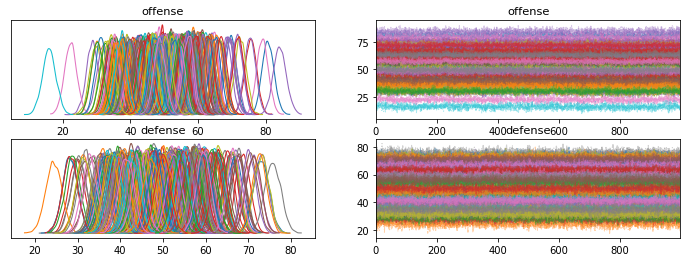

<IPython.core.display.Javascript object>

In [191]:
az.plot_trace(
    trace,
    var_names=[
        "offense",
        "defense",
    ],
    compact=True,
    combined=True,
)